In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import nltk
from afinn import Afinn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, f1_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [3]:
data = pd.read_csv('data/interview_data.csv').set_index('RowId')
data['date'] = pd.to_datetime(data.date)

# EDA

In [4]:
data.isna().sum()

team1    0
team2    0
date     0
name     0
job      0
text     0
dtype: int64

No missing data.

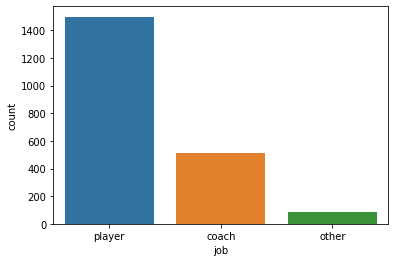

In [5]:
sns.countplot(data.job, order=data.job.value_counts().index);

In [6]:
data = data[data.job != 'other']

Let's study only the players' and coaches' interviews.

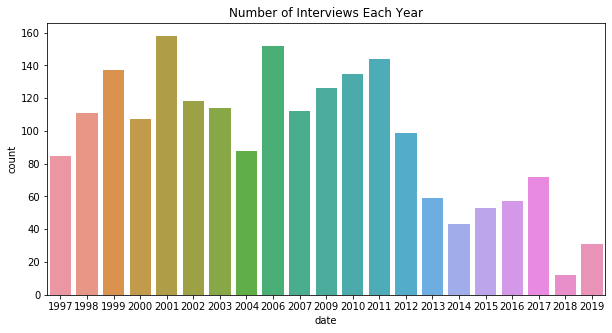

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(data.date.map(lambda x: x.year)).set_title('Number of Interviews Each Year');

In [8]:
data['num_words'] = data.text.map(lambda x: len(x.split()))

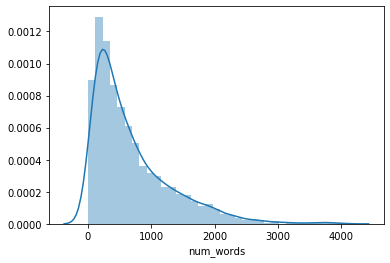

In [9]:
sns.distplot(data.num_words);

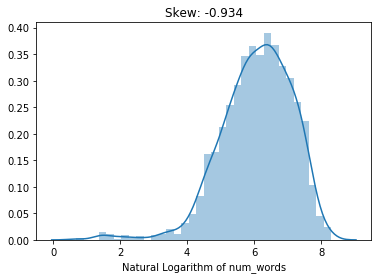

In [35]:
sns.distplot(np.log(data.num_words)).set(xlabel='Natural Logarithm of num_words', title='Skew: {}'.format(round(np.log(data.num_words).skew(),3)));

The log distribution of word count is only moderately skewed. Perhaps we can add interview length to the list of natural ("naturally" is loosely defined) phenomena (rainfall, inflation rates, etc.) that tend to have a log-normal distribution. 

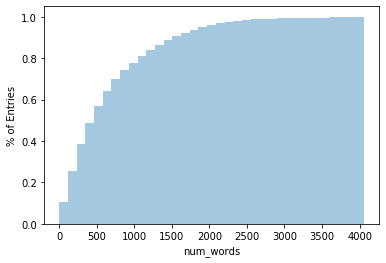

In [37]:
kwargs = {'cumulative': True}
sns.distplot(data.num_words, kde=False, norm_hist=True, hist_kws=kwargs).set(ylabel='% of Entries');

Roughly 50% of interviews have 500 or fewer words. 
# Sentiment Analysis

In [12]:
afinn = Afinn()
# this takes 50 seconds
data['sentiment'] = data.text.map(lambda x: afinn.score(x)/len(x.split()))

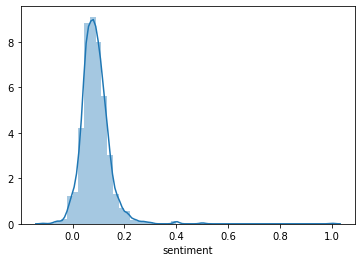

In [13]:
sns.distplot(data.sentiment);

We use the Afinn lexicon-based sentiment scoring method. It scores a list of words by summing each word's sentiment score. We divide by the number of words in order to limit the effects interview length. 

In [14]:
low_sent = data.loc[data.sentiment.idxmin()]
print(low_sent.drop(columns=['text']))
print('\n'+low_sent.text)

team1                                             mighty ducks
team2                                                   devils
date                                       2003-05-31 00:00:00
name                                            grant marshall
job                                                     player
text         well they battled hard they came out at home w...
num_words                                                  108
sentiment                                            -0.111111
Name: 1085, dtype: object

well they battled hard they came out at home which we expected they would we didn't have that bad of a first period we are starting to pick up a little bit in the second but they just kept coming hard and we got a bad break for us there with marty losing his stick there but we're a confident team and we're going to keep battling. a couple swear words came to mind but it's a mistake marty's been great for us all year but that happens that's hockey unfortunately we d

In [15]:
high_sent = data.loc[data.sentiment.idxmax()]
print(high_sent.drop(columns=['text']))
print('\n'+high_sent.text)

team1                  red wings
team2                     flyers
date         1997-06-07 00:00:00
name                gary meagher
job                       player
text                thanks terry
num_words                      2
sentiment                      1
Name: 1645, dtype: object

thanks terry


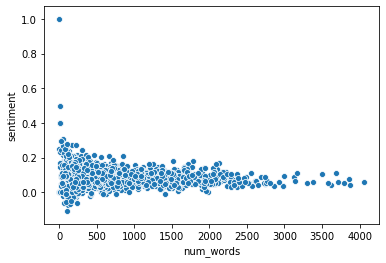

In [16]:
sns.scatterplot(data.num_words, data.sentiment);

In the above graph and the output of the above cell we see the downside of dividing by the number of words. The word "thanks" has a high positive sentiment score, "terry" is neutral, and the final score is half the score of "thanks". Each individual word in a shorter sentence has a larger impact on the sentiment, so we can expect the variance of the sentiment of these sentences to be large. Larger variant sentence types are more likely to be at the extremes, so we have a two words sentence as the most positive sentence. 

Does it follow that scaling sentiment by sentence length is a bad idea? I think not. See the following graph of num_words vs unscaled sentiment. 

0.8301617223783482


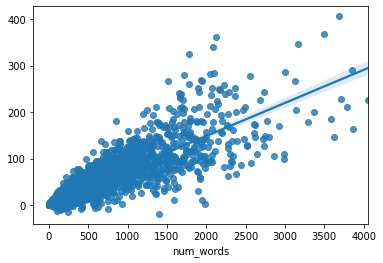

In [39]:
sns.regplot(data.num_words, data.sentiment*data.num_words);
print(data.num_words.corr(data.sentiment*data.num_words))

We have a strong positive correlation (Pearson coefficient > 0.8) between num_words and sentiment. Clearly this is unrealistic. Let's stick to our scaled sentiment.

Let's see how the sentiment distributions of coaches and players differ.

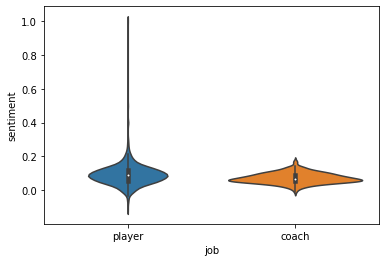

In [18]:
sns.violinplot(x='job', y='sentiment', data=data);

As I noted in [this Medium article](https://medium.com/analytics-vidhya/a-quantitative-study-of-nhl-interviews-25b28821364b), "Note that coaches have a slightly less positive and moderately less variable interview sentiment. Anyone who’s seen the reaction of players (cheering pileup) and coaches (smiling handshake) to a game-winning goal will find this unsurprising."
# "Selfishness" Analysis

In [19]:
selfish_lexicon = {
    'i':1,'my':1,'i\'m':1,'i\'ve':1,'i\'ll':1,'myself':1,
    'we':-1, 'our':-1,'us':-1,'we\'re':-1,'we\'ve':-1,
    'we\'ll':-1,'ourselves':-1
}
start_time = time.time()
data['selfishness'] = data.text.apply(lambda x: sum([selfish_lexicon.get(w, 0) for w in x.split()])/len(x.split()))
print(time.time() - start_time)

0.31597471237182617


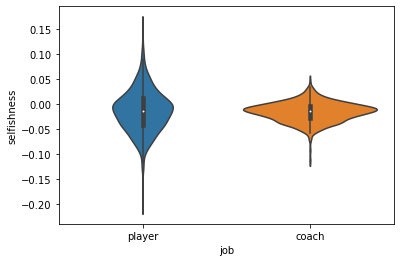

In [20]:
sns.violinplot(x='job', y='selfishness', data=data);

I've created a lexicon-based selfishness scoring method. It assigns postive selfishness scores to first person singular pronouns and negative selfishness scores to first person plural pronouns.

The means of the two distributions are roughly equal, but coaches once again have a distribution with lower variance.

# Player vs Coach Classification
Can we train a model to determine whether a given interview transcript was from a coach or a player?

In [21]:
np.random.seed(314)
mask = np.random.random(len(data)) < 0.8
y = (data.job == 'player').astype(int).values
X = data.text.values
y_train = y[mask]
y_test = y[~mask]
X_train = X[mask]
X_test = X[~mask]
print((y_train==1).sum()/len(y_train))

0.7458808618504436


Let's bear in mind that the training set (and likely the test set, but let's pretend we don't know that) has an imbalance of 75%/25%.

Our model will be logistic regression with the ft-idf as features. This is a simple yet often highly accurate model. Neural models such as RNNs or BERT may be a step up, but they have a high overhead and generally require large amounts of data in order to outperform more traditional models.

{'C': 1000}


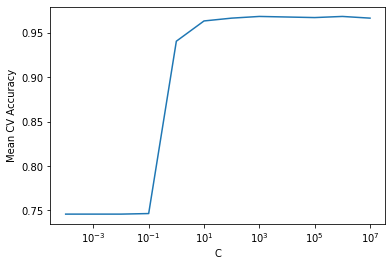

In [22]:
params = {
    'C': [10**i for i in range(-4, 8)]
}
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=314)
lr_pipe_grid = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    GridSearchCV(LogisticRegression(max_iter=10**4), params, cv=kfold)
)
lr_pipe_grid.fit(X_train, y_train)
grid = lr_pipe_grid[2]
print(grid.best_params_)
if len(params) == 1:
    param_name = next(iter(params))
    param_list = next(iter(params.values()))
    accs = np.array(grid.cv_results_['mean_test_score'])
    sns.lineplot(param_list, accs).set(xscale='log', xlabel=param_name, ylabel='Mean CV Accuracy');

{'C': 1000000}
171.33123803138733


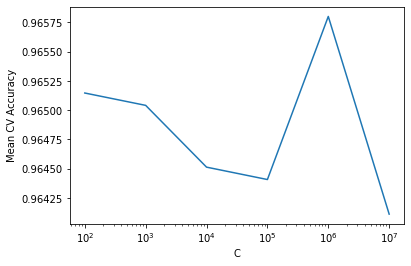

In [23]:
# this cell takes approximately 3 minutes to run
start_time = time.time()
params = {
    'C': [10**i for i in range(2, 8)]
}
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=30, random_state=314)
lr_pipe_grid = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    GridSearchCV(LogisticRegression(max_iter=10**4), params, cv=kfold)
)
lr_pipe_grid.fit(X_train, y_train)
grid = lr_pipe_grid[2]
print(grid.best_params_)
if len(params) == 1:
    param_name = next(iter(params))
    param_list = next(iter(params.values()))
    accs = np.array(grid.cv_results_['mean_test_score'])
    sns.lineplot(param_list, accs).set(xscale='log', xlabel=param_name, ylabel='Mean CV Accuracy');
print(time.time() - start_time)

Looks like 10\*\*6 is our optimal C parameter.

In [24]:
lr_pipe = make_pipeline(
    CountVectorizer(), 
    TfidfTransformer(), 
    LogisticRegression(C=10**6, class_weight='balanced')
)

In [25]:
lr_pipe.fit(X_train, y_train);

In [26]:
y_pred = lr_pipe.predict(X_test)
(y_pred == y_test).sum()/len(y_pred)

0.9540229885057471

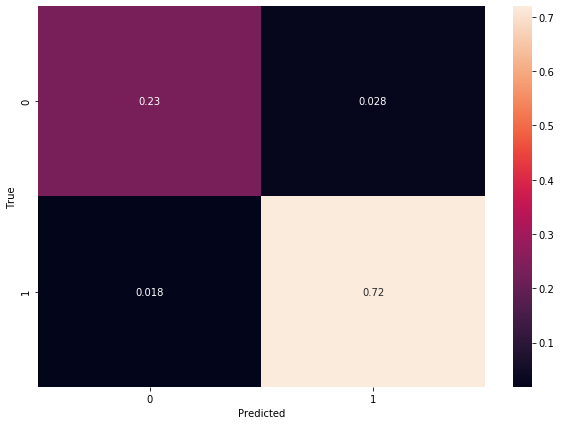

In [27]:
fig, ax = plt.subplots(figsize = (10,7))
conf_mat = confusion_matrix(y_test, y_pred)/len(y_pred)
sns.heatmap(conf_mat, annot=True, ax=ax).set(xlabel='Predicted', ylabel='True');

In [28]:
prob_preds = lr_pipe.predict_proba(X_test)
prob_preds = prob_preds[:,1]

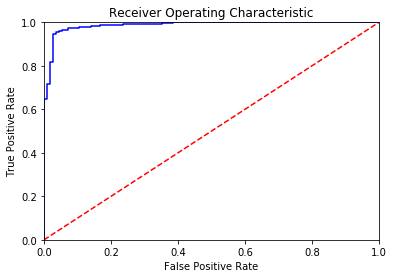

'AUC: 0.987'

In [29]:
fpr, tpr, threshold = roc_curve(y_test, prob_preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
'AUC: {}'.format(round(roc_auc, 3))

ROC curves can give an overly optimistic estimate of model performance when the dataset is imbalanced, so we'll have to ignore the above plot. A much better alternative in this case is a precision-recall curve. 

'F1: 0.969, AUC: 0.995'

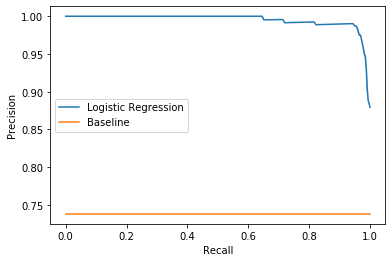

In [30]:
lr_prec, lr_rec, _ = precision_recall_curve(y_test, prob_preds)
baseline = (y_test==1).sum()/len(y_test)
sns.lineplot(lr_rec, lr_prec, label='Logistic Regression').set(xlabel='Recall', ylabel='Precision');
sns.lineplot([0, 1], [baseline, baseline], label='Baseline');
lr_f1 = f1_score(y_test, y_pred)
lr_auc = auc(lr_rec, lr_prec)
'F1: {}, AUC: {}'.format(round(lr_f1, 3), round(lr_auc, 3))

Note that I adapted the code from [Machine Learning Mastery Article](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) to make the above plots. 

# Conclusion
We've studied the difference between coaches and players along two axes, sentiment and selfishness. We've created a binary classification model with a test F1 score of 0.97. 

In other work I used this dataset to train an RNN-based Facebook Messenger chatbot to respond to messages as a hockey player might. More precisely, if you send the bot the beginning of an interview response, it will respond with a 5-sentence continuation of that response. For example, it could receive "Well you know" and respond with "Well you know we played hard out there and...". Follow [this](m.me/102447081166159) link to interact with the chatbot and [this](https://medium.com/analytics-vidhya/nhl-player-chatbot-5c882e330fb7) link to read the Medium article where I explain how I created the bot (and how you can too!).

I've had a lot of fun with this dataset and I hope you can too!